In [ ]:
!kaggle datasets download -d datasnaek/mbti-type
!unzip mbti-type.zip
!pip install catboost
!pip install xgboost

In [ ]:
import re
import csv
import string
import pickle
import collections
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings


nltk.download('wordnet')
nltk.download('punkt')

In [ ]:
!unzip data/personalitycafe/test.zip -d data/personalitycafe

Making map from types to ints and vice versa

In [26]:
mbti_map = dict(
    zip(
        [
            "ISTJ", "ISFJ", "INFJ", "INTJ", "ISTP", "ISFP", "INFP", "INTP",
            "ESTP", "ESFP", "ENFP", "ENTP", "ESTJ", "ESFJ", "ENFJ", "ENTJ"
        ],
        range(16)
    )
)

reverse_mbti_map = dict(zip(mbti_map.values(), mbti_map.keys()))

Uploading datasets

In [4]:
# first dataset from kaggle.com/datasets/datasnaek/mbti-type
data1 = pd.read_csv("data/mbti_1.csv")

# second dataset have been parsed from personalitycafe.com sub-forums
dataset = []

for mbti_type in mbti_map.keys():
    with open(f"data/personalitycafe/{mbti_type}.txt", 'r') as f:
        content = f.read()
        # removing multiple whitespaces and \n
        content = " ".join(re.split("\s+", content, flags=re.UNICODE))
        # cutting into chunks, assuming, that 893 is an average single chunks length
        chunks = [content[0+i:893+i] for i in range(0, len(content), 893)]
        for chunk in chunks:
            dataset += [{"type": mbti_type, "posts": chunk}]


# dumping dataset to csv file
# field names
fields = ['type', 'posts']
filename = "additional_data.csv"

# writing to csv file
with open(filename, 'w') as csvfile:
    # creating a csv dict writer object
    writer = csv.DictWriter(csvfile, fieldnames=fields)

    # writing headers (field names)
    writer.writeheader()

    # writing data rows
    writer.writerows(dataset)


data2 = pd.read_csv("additional_data.csv")

# push these two into one dataset
data = pd.concat([data1, data2], ignore_index=True)
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


**Printing some statistics:**

<Figure size 640x480 with 0 Axes>

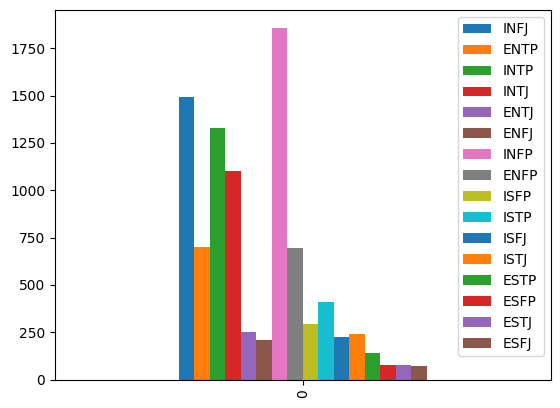

In [5]:
counts = collections.Counter(data["type"])
plotdata = pd.DataFrame(counts, index=[0])
plt.figure();
plotdata.plot.bar();

**Applying text preprocessing, lemmatization and we remove words that are too frequent and rarely encountered:**

In [6]:
def reg_handling(content: str) -> str:
    """
    deleting punctuation, links, etc from DataFrame
    """

    content = re.sub(r"http\S*", " ", content.lower().lstrip("'"))
    content = re.sub(r'\|{3,}', ' ', content)
    content = content.translate(str.maketrans(' ', ' ', string.punctuation))
    content = re.sub(r'[^A-z]', ' ', content)

    return content


def applying_stemmer(text: str) -> str:
    stemmer = SnowballStemmer('english')
    new_text = [stemmer.stem(word) for word in text.split()]
    return " ".join(new_text)


def applying_lemmatization(text: str) -> str:
    lemmatizer = WordNetLemmatizer()
    lst = text.split()
    lemmatized_lst = [lemmatizer.lemmatize(word) for word in lst]
    return " ".join(lemmatized_lst)


def delete_rare_words(column) -> list[str]:
    """
    returns new vocabulary of document, without rare words
    """
    words = collections.Counter()
    for text in data[column]:
        for word in text.split():
            words[word] += 1

    # delete words if their number of occurrences is less than 20
    new_vocab = set()
    counter_threshold = 20

    for char, cnt in words.items():
        if cnt > counter_threshold:
            new_vocab.add(char)
    return new_vocab

def applying_vocab(text: str, vocab: list[str]) -> str:
    """
    reducing inappropriate words from DataFrame,
    such as stop words and too rare words
    """
    new_text = [word for word in text.split() if word in vocab]
    return " ".join(new_text)


data["posts"] = data["posts"].apply(reg_handling)
data["postl"] = data["posts"]
data["posts"] = data["posts"].apply(applying_stemmer)
data["postl"] = data["postl"].apply(applying_lemmatization)

columns = ["postl", "posts"]

# appyling new vocabulary for both:
# data with stemmer and data with lemmatization
for column in columns:
    new_vocab = delete_rare_words(column)
    data[column] = data[column].apply(applying_vocab, args=(new_vocab,))

**Encode data["type"] labels to numbers from 0 up to 15:**

In [7]:
def labels_renaming(mbti_type: str) -> int:
    return mbti_map[mbti_type]


data["type"] = data["type"].apply(labels_renaming)
data.head()

,type,posts,postl
0,2,and intj moment not top ten play prank what ha...,and intj moment not top ten play prank what ha...
1,11,im find the lack of me in these post veri alar...,im finding the lack of me in these post very s...
2,7,good one cours to which i say i know that my b...,good one course to which i say i know thats my...
3,3,dear intp i enjoy our convers the other day es...,dear intp i enjoyed our conversation the other...
4,15,your fire that anoth silli misconcept that app...,youre fired thats another silly misconception ...


**Fitting the vectorizer and model, we'll use tf-idf, xgboost and catboost:**

In [8]:
def splitting_data(df: pd.DataFrame, column: str):
    train_x, test_x, train_y, test_y = train_test_split(
        data[column],
        data["type"],
        train_size=0.8,
        random_state=42
    )
    return train_x, test_x, train_y, test_y


def pipelines():
    pipeline_logreg = Pipeline([
        ('tf-idf', TfidfVectorizer(stop_words='english')),
        ('log-reg', LogisticRegression())
    ])

    pipeline_xgboost = Pipeline([
        ('tf-idf', TfidfVectorizer(stop_words='english')),
        (
            'xgboost',
            XGBClassifier(
                max_depth=5,
                n_estimators=50,
                learning_rate=0.1
            )
        )
    ])

    pipeline_catboost = Pipeline([
        ('tf-idf', TfidfVectorizer(stop_words='english')),
        (
            'catboost',
            CatBoostClassifier(
                loss_function='MultiClass',
                eval_metric='MultiClass',
                task_type='GPU',
                verbose=False
            )
        )
    ])

    return pipeline_logreg, pipeline_xgboost, pipeline_catboost


def pipeline_RandForestClassifier():
    pipeline_forest = Pipeline([
            ('tf-idf', TfidfVectorizer(stop_words='english')),
            ('rfc', RandomForestClassifier())
    ])
    return pipeline_forest


@ignore_warnings(category=ConvergenceWarning)
def fitting(train_x, train_y):
    pipeline_logreg, pipeline_xgboost, pipeline_catboost = pipelines()
    pipeline_logreg.fit(train_x, train_y)
    pipeline_xgboost.fit(train_x, train_y)
    pipeline_catboost.fit(train_x, train_y)

    return pipeline_logreg, pipeline_xgboost, pipeline_catboost


**Results:**

In [9]:
for column in columns:
    train_x, test_x, train_y, test_y = splitting_data(data, column)

    pipeline_logreg, pipeline_xgboost, pipeline_catboost = fitting(train_x, train_y)
    cb = f1_score(test_y, pipeline_catboost.predict(test_x), average="weighted")
    xgb = f1_score(test_y, pipeline_xgboost.predict(test_x), average="weighted")
    logreg = f1_score(test_y, pipeline_logreg.predict(test_x), average="weighted")

    info_str = "stemming" if column == "posts" else "lemmatization"

    print(f"catboost f1_score({info_str}): {cb:.3f}")
    print(f"xgboost  f1_score({info_str}): {xgb:.3f}")
    print(f"logistic regression f1_score({info_str}): {logreg:.3f}\n")

catboost f1_score(lemmatization): 0.671
xgboost  f1_score(lemmatization): 0.664
logistic regression f1_score(lemmatization): 0.621

catboost f1_score(stemming): 0.676
xgboost  f1_score(stemming): 0.671
logistic regression f1_score(stemming): 0.645



As we can see, results with stemmer are better

**Let's try GridSearch on RandomForest:**

In [10]:
RFC = pipeline_RandForestClassifier()

param_grid = {
    'rfc__n_estimators': [100, 150],
    'rfc__max_depth': [5, 10, 15],
    'rfc__min_samples_split': [5, 10]
}

grid_search = GridSearchCV(estimator=RFC, param_grid=param_grid, cv=5, error_score='raise')
train_x, test_x, train_y, test_y = splitting_data(data, "posts")
grid_search.fit(train_x, train_y)

print(f"Best parameters: {grid_search.best_params_}\nBest score: {grid_search.best_score_}")

Best parameters: {'rfc__max_depth': 15, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 100}
Best score: 0.42825754240892744


**Saving best model and vocabulary:**

In [14]:
# dumping vocabulary


with open("bot/compiled/new_vocab.txt", "w") as outfile:
    outfile.write("\n".join(new_vocab))


# dumping pipeline
filename = 'bot/compiled/finalized_model.pkl'
pickle.dump(pipeline_catboost, open(filename, 'wb'))

Making confusion matrix for best model (catboost with stemmer)

In [19]:
pred_y = pipeline_catboost.predict(test_x)

cb = f1_score(test_y, pred_y, average="weighted")

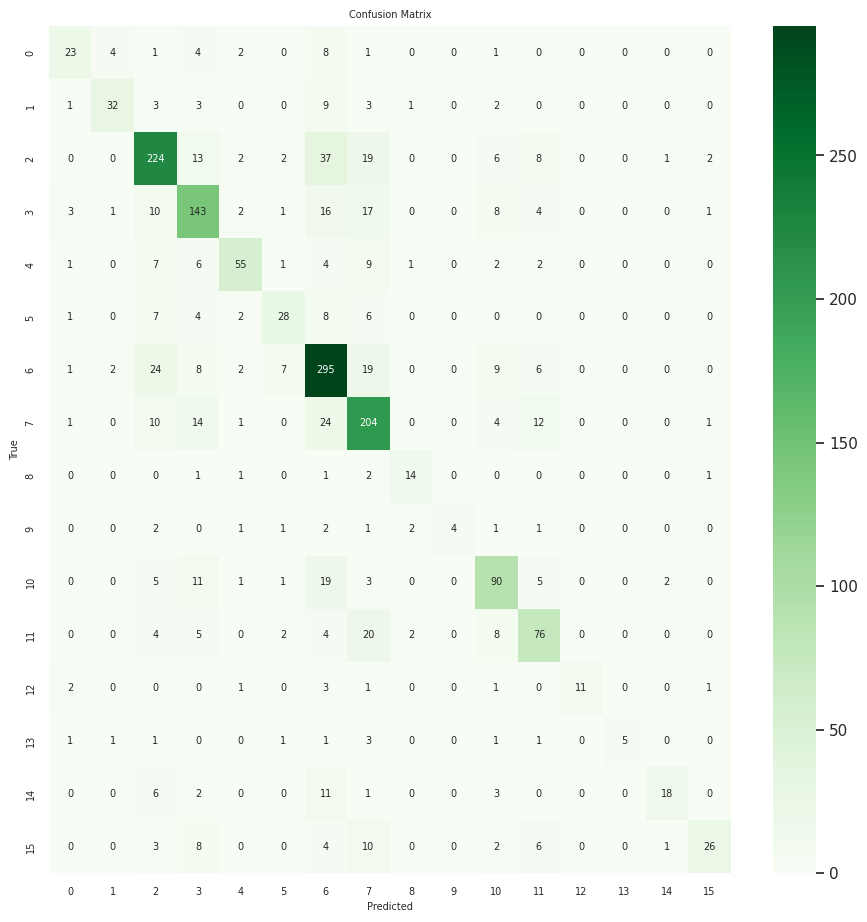

In [20]:
def generate_confusion_matrix(matrix):
    matrix = matrix.astype('float')

    sns.set(rc={'figure.figsize': (11, 11)})
    figure = sns.heatmap(
        matrix,
        annot=True,
        cmap='Greens',
        fmt='.0f',
        annot_kws={"size": 7}
    )

    figure.tick_params(labelsize=7)

    plt.xlabel('Predicted', fontsize=7)
    plt.ylabel('True', fontsize=7)
    plt.title('Confusion Matrix', fontsize=7)
    plt.show()


df_confusion = confusion_matrix(test_y, pred_y)
generate_confusion_matrix(df_confusion)


In [27]:
reverse_mbti_map[2], reverse_mbti_map[8]

('INFJ', 'ESTP')

the model is most often confused in INFJ and ESTP

Lets gridsearch catboost with stemmer to achive better result

In [ ]:
pipeline_catboost = Pipeline([
    ('tf-idf', TfidfVectorizer(stop_words='english')),
    (
        'catboost',
        CatBoostClassifier(
            loss_function='MultiClass',
            eval_metric='MultiClass',
            task_type='GPU',
            verbose=False,
            custom_metric='F1'
        )
    )
])


train_x, test_x, train_y, test_y = splitting_data(data, 'posts')

parameters = {
    'catboost__depth'         : [4,6,8,10],
    'catboost__learning_rate' : [0.01,0.03,0.04],
    'catboost__iterations'    : [10,30,50,70,90,100]
}

Grid_CBC = GridSearchCV(
    estimator=pipeline_catboost,
    param_grid=parameters,
    cv=2,
    n_jobs=-1
)

Grid_CBC.fit(train_x, train_y)